# Retail Investor Sentiment Analysis as a Predictor of Market Performance

In [73]:
# Standard Packages
import pandas as pd
import numpy as np
import markdown
import os
from datetime import datetime
import yfinance as yf
import re

    # Progress Bar
from tqdm.notebook import tqdm
#tqdm.pandas(desc="progress-bar")


# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Natural Language Processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# SKLearn Modules
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, log_loss, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cnade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## The Business Problem

#### We've been tasked by Point72 to conduct a sentiment analysis on a forum of retail investors, in order for them to implement them on top of their existing systematic trading algorithms

## Data Preparation and Understanding

#### For our data, we scraped r/Investing Daily Discussion Posts and Comments to gauge investor sentiment on a given trading day. We also will use yahoo finance data on the S&P 500 for our classification analysis

In [74]:
# Reddit Data
comments = pd.read_csv('comment_data.csv')
posts = pd.read_csv('post_data.csv')
# Yahoo Finance Data
market_data = yf.Ticker('^GSPC').history(period = '2y')

#### Dropping Useless Columns

In [75]:
posts.drop(['Unnamed: 0', 'body'], axis = 1, inplace = True)
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      250 non-null    object 
 1   url        250 non-null    object 
 2   id         250 non-null    object 
 3   comms_num  250 non-null    int64  
 4   created    250 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 9.9+ KB


In [76]:
comments.drop('Unnamed: 0', axis = 1, inplace = True)
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108051 entries, 0 to 108050
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   comment_id         108051 non-null  object 
 1   comment_parent_id  108051 non-null  object 
 2   comment_body       108051 non-null  object 
 3   comment_link_id    108051 non-null  object 
 4   comment_score      108051 non-null  int64  
 5   comment_time       108051 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.9+ MB


In [77]:
market_data.drop(['High','Low','Volume','Dividends','Stock Splits'], axis = 1, inplace = True)

## Data Preparation

#### Converting comment_time, post_time from unix to datetime object

In [78]:
comments['comment_time'] = pd.to_datetime(comments['comment_time'], unit = 's')
posts['created'] = pd.to_datetime(posts['created'], unit = 's')

In [79]:
comments.tail()

,comment_id,comment_parent_id,comment_body,comment_link_id,comment_score,comment_time
108046,i383kpe,t1_i383899,I'm not sure if I totally agree with that stat...,t3_ttmn8e,2,2022-04-03 14:09:27
108047,i35qfix,t1_i327mum,"16 next week on Ukrain news, technicals out of...",t3_ttmn8e,1,2022-04-02 22:26:44
108048,i2zu7fi,t1_i2zu2l6,Again. That's the problem. You don't care\n\nY...,t3_ttmn8e,1,2022-04-01 15:38:50
108049,i3872do,t1_i383kpe,It is not my own opinion (when I buy index fun...,t3_ttmn8e,2,2022-04-03 14:36:45
108050,i2zumck,t1_i2zu7fi,[deleted],t3_ttmn8e,3,2022-04-01 15:41:36


In [80]:
# New Column for just date
year_month_day_format = '%Y-%m-%d'
posts['created_date']= posts['created'].apply(lambda x: x.strftime(year_month_day_format))
comments['created_date']= comments['comment_time'].apply(lambda x: x.strftime(year_month_day_format))

#### Merging Posts and Comments

In [81]:
Posts_Comments = comments.merge(posts, how = 'left', on = 'created_date')
Posts_Comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108051 entries, 0 to 108050
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   comment_id         108051 non-null  object        
 1   comment_parent_id  108051 non-null  object        
 2   comment_body       108051 non-null  object        
 3   comment_link_id    108051 non-null  object        
 4   comment_score      108051 non-null  int64         
 5   comment_time       108051 non-null  datetime64[ns]
 6   created_date       108051 non-null  object        
 7   title              103731 non-null  object        
 8   url                103731 non-null  object        
 9   id                 103731 non-null  object        
 10  comms_num          103731 non-null  float64       
 11  created            103731 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 10.7+ MB


About 5k comments were posted on the weekend. Since that's a relatively small subset covering a time where stocks aren't traded, we can drop them.

In [82]:
Posts_Comments.dropna(subset = ['created'], axis = 0, inplace = True)
Posts_Comments.head()

,comment_id,comment_parent_id,comment_body,comment_link_id,comment_score,comment_time,created_date,title,url,id,comms_num,created
0,je9wqz5,t3_126hopo,Michael Burry saying he was wrong to say sell ...,t3_126hopo,8,2023-03-30 14:05:20,2023-03-30,r/Stocks Daily Discussion & Options Trading Th...,https://www.reddit.com/r/stocks/comments/126ho...,126hopo,91.0,2023-03-30 09:30:12
1,je9kvzm,t3_126hopo,Anyone have stocks they bought between Oct 202...,t3_126hopo,9,2023-03-30 12:32:24,2023-03-30,r/Stocks Daily Discussion & Options Trading Th...,https://www.reddit.com/r/stocks/comments/126ho...,126hopo,91.0,2023-03-30 09:30:12
2,je9qore,t3_126hopo,What if the FRC July 2024 40c is this year's T...,t3_126hopo,3,2023-03-30 13:20:12,2023-03-30,r/Stocks Daily Discussion & Options Trading Th...,https://www.reddit.com/r/stocks/comments/126ho...,126hopo,91.0,2023-03-30 09:30:12
3,je9lh7w,t3_126hopo,Morgan Stanley downgrades Charles Schwab to Eq...,t3_126hopo,5,2023-03-30 12:37:33,2023-03-30,r/Stocks Daily Discussion & Options Trading Th...,https://www.reddit.com/r/stocks/comments/126ho...,126hopo,91.0,2023-03-30 09:30:12
4,je9w81a,t3_126hopo,"Nasdaq confirmed in a new bull market, everyon...",t3_126hopo,5,2023-03-30 14:01:34,2023-03-30,r/Stocks Daily Discussion & Options Trading Th...,https://www.reddit.com/r/stocks/comments/126ho...,126hopo,91.0,2023-03-30 09:30:12


Let's now drop more columns that we do not need or are redundant

In [83]:
Posts_Comments.drop(columns = ['title','url','comment_id','comment_parent_id'], inplace = True)

In [84]:
Posts_Comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103731 entries, 0 to 108050
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   comment_body     103731 non-null  object        
 1   comment_link_id  103731 non-null  object        
 2   comment_score    103731 non-null  int64         
 3   comment_time     103731 non-null  datetime64[ns]
 4   created_date     103731 non-null  object        
 5   id               103731 non-null  object        
 6   comms_num        103731 non-null  float64       
 7   created          103731 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 7.1+ MB


Visualizing Distribution of Comments by Date

Text(0.5, 1.0, 'Distribution of comments by day')

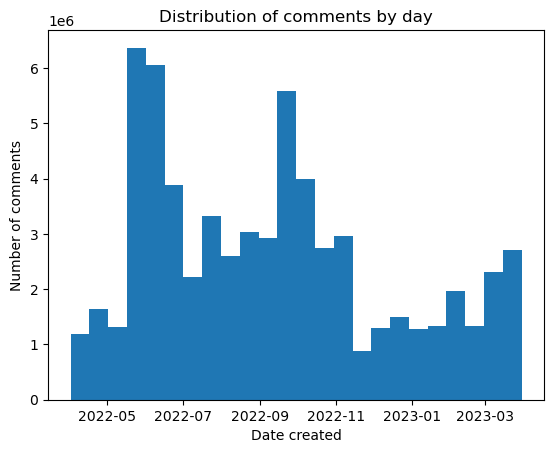

In [85]:
plt.hist(Posts_Comments['created'], bins=24, weights = Posts_Comments['comms_num'])
plt.xlabel('Date created')
plt.ylabel('Number of comments')
plt.title('Distribution of comments by day')

S+P 500 Trend Data

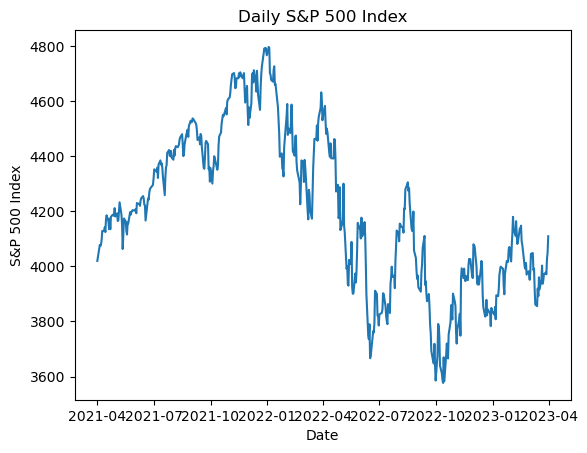

In [86]:
plt.plot(market_data['Close'])

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('S&P 500 Index')

# Set the plot title
plt.title('Daily S&P 500 Index')

# Display the plot
plt.show()

In [87]:
# Fixing created_date column
Posts_Comments['date'] = pd.to_datetime(Posts_Comments['created_date'])
Posts_Comments.drop(['created_date'], axis = 1, inplace = True)

In [88]:
Posts_Comments.head()

,comment_body,comment_link_id,comment_score,comment_time,id,comms_num,created,date
0,Michael Burry saying he was wrong to say sell ...,t3_126hopo,8,2023-03-30 14:05:20,126hopo,91.0,2023-03-30 09:30:12,2023-03-30
1,Anyone have stocks they bought between Oct 202...,t3_126hopo,9,2023-03-30 12:32:24,126hopo,91.0,2023-03-30 09:30:12,2023-03-30
2,What if the FRC July 2024 40c is this year's T...,t3_126hopo,3,2023-03-30 13:20:12,126hopo,91.0,2023-03-30 09:30:12,2023-03-30
3,Morgan Stanley downgrades Charles Schwab to Eq...,t3_126hopo,5,2023-03-30 12:37:33,126hopo,91.0,2023-03-30 09:30:12,2023-03-30
4,"Nasdaq confirmed in a new bull market, everyon...",t3_126hopo,5,2023-03-30 14:01:34,126hopo,91.0,2023-03-30 09:30:12,2023-03-30


In [89]:
# Fixing Created column to just show date
Posts_Comments['Date_Created'] = Posts_Comments['created'].dt.date
Posts_Comments.head()

,comment_body,comment_link_id,comment_score,comment_time,id,comms_num,created,date,Date_Created
0,Michael Burry saying he was wrong to say sell ...,t3_126hopo,8,2023-03-30 14:05:20,126hopo,91.0,2023-03-30 09:30:12,2023-03-30,2023-03-30
1,Anyone have stocks they bought between Oct 202...,t3_126hopo,9,2023-03-30 12:32:24,126hopo,91.0,2023-03-30 09:30:12,2023-03-30,2023-03-30
2,What if the FRC July 2024 40c is this year's T...,t3_126hopo,3,2023-03-30 13:20:12,126hopo,91.0,2023-03-30 09:30:12,2023-03-30,2023-03-30
3,Morgan Stanley downgrades Charles Schwab to Eq...,t3_126hopo,5,2023-03-30 12:37:33,126hopo,91.0,2023-03-30 09:30:12,2023-03-30,2023-03-30
4,"Nasdaq confirmed in a new bull market, everyon...",t3_126hopo,5,2023-03-30 14:01:34,126hopo,91.0,2023-03-30 09:30:12,2023-03-30,2023-03-30


Create % Change Column for Categorization

In [90]:
market_data.reset_index(inplace = True)
market_data['Date'] = market_data['Date'].dt.date
market_data['% Change'] = (market_data["Close"] - market_data["Open"]) / market_data["Open"] * 100

In [91]:
market_data.head()

,Date,Open,Close,% Change
0,2021-04-01,3992.780029,4019.870117,0.678477
1,2021-04-05,4034.439941,4077.909912,1.077472
2,2021-04-06,4075.570068,4073.939941,-0.039998
3,2021-04-07,4074.290039,4079.949951,0.138918
4,2021-04-08,4089.949951,4097.169922,0.176530


Categorize whether Market was Up or Down

In [92]:
market_data['Up_Down'] = market_data['% Change'].apply(lambda x: 1 if x > 0 else 0)

In [93]:
market_data

,Date,Open,Close,% Change,Up_Down
0,2021-04-01,3992.780029,4019.870117,0.678477,1
1,2021-04-05,4034.439941,4077.909912,1.077472,1
2,2021-04-06,4075.570068,4073.939941,-0.039998,0
3,2021-04-07,4074.290039,4079.949951,0.138918,1
4,2021-04-08,4089.949951,4097.169922,0.176530,1
...,...,...,...,...,...
499,2023-03-27,3982.929932,3977.530029,-0.135576,0
500,2023-03-28,3974.129883,3971.270020,-0.071962,0
501,2023-03-29,3999.530029,4027.810059,0.707084,1
502,2023-03-30,4046.739990,4050.830078,0.101071,1


### Natural Language Processing

We just want the comment body, and a thing to identify it by. Let's use the comment_time column to do that. We will also keep the comment_score column to amplify sentiments if a post was up or down voted.

In [94]:
Comment_NLP = Posts_Comments[['comment_body','comment_score','Date_Created']].set_index('Date_Created')
Comment_NLP.reset_index(inplace = True)
Comment_NLP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103731 entries, 0 to 103730
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Date_Created   103731 non-null  object
 1   comment_body   103731 non-null  object
 2   comment_score  103731 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


Cleaning Text

In [95]:
# Get English Stopwords
stop = set(stopwords.words('english'))
# Add some of our own stopwords
new_words = ['im','one','ive']
stop.update(new_words)
# Split comment for each individual words, make each word lowercase, remove non-alphabetic characters, remove stopwords
Comment_NLP['comment_body'] = Comment_NLP['comment_body'].apply(lambda x: " ".join(x.lower() for x in x.split())) # convert to lowercase
Comment_NLP['comment_body'] = Comment_NLP['comment_body'].apply(lambda x: re.sub(r'http\S+|[^a-zA-Z\s]', '', x)) # Remove non-alphabetic characters
Comment_NLP['comment_body'] = Comment_NLP['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) # remove stopwords

In [96]:
Comment_NLP.head()

,Date_Created,comment_body,comment_score
0,2023-03-30,michael burry saying wrong say sell lol,8
1,2023-03-30,anyone stocks bought oct march try discuss peo...,9
2,2023-03-30,frc july c years tsla c,3
3,2023-03-30,morgan stanley downgrades charles schwab equal...,5
4,2023-03-30,nasdaq confirmed new bull market everyone fomo,5


### We will now use Vader's Sentiment Intensity Analyzer to get the sentiment of each comment

In [97]:
sia = SentimentIntensityAnalyzer()
Comment_NLP['scores'] = Comment_NLP['comment_body'].apply(lambda body: sia.polarity_scores(str(body)))

In [98]:
# Making New Column for Compound Score of each Comment, dropping scores column
Comment_NLP['compound']=Comment_NLP['scores'].apply(lambda score_dict:score_dict['compound'])
Comment_NLP.drop(['scores'], axis = 1, inplace = True)

In [99]:
Comment_NLP

,Date_Created,comment_body,comment_score,compound
0,2023-03-30,michael burry saying wrong say sell lol,8,-0.0772
1,2023-03-30,anyone stocks bought oct march try discuss peo...,9,0.3612
2,2023-03-30,frc july c years tsla c,3,0.0000
3,2023-03-30,morgan stanley downgrades charles schwab equal...,5,-0.5106
4,2023-03-30,nasdaq confirmed new bull market everyone fomo,5,0.0000
...,...,...,...,...
103726,2022-04-01,thing clear u understand u opened edgar page s...,-1,0.9118
103727,2022-04-01,thats problem dont care others long get ahead ...,0,-0.3459
103728,2022-04-01,thisll last response matter dont care,0,-0.3670
103729,2022-04-01,thats problem dont care good person,1,-0.7740


#### Aggregate Data by date, by average sentiment score

In [100]:
agg_data = Comment_NLP.groupby('Date_Created').agg(avg_score=('compound', 'mean'), num_comments=('compound', 'count'))

Aggregated Data Visualization

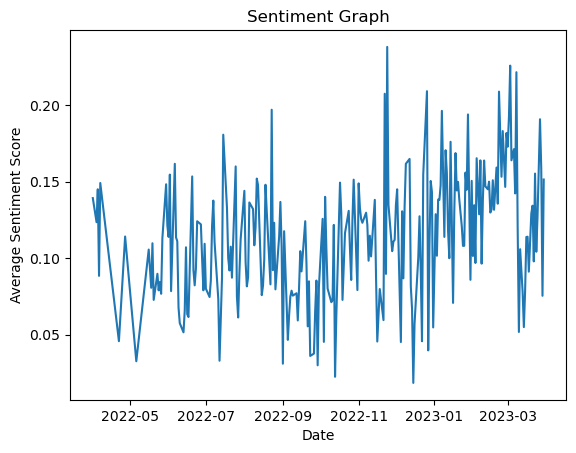

In [101]:
plt.plot(agg_data['avg_score'])

plt.xlabel('Date')

plt.ylabel('Average Sentiment Score')

plt.title('Sentiment Graph')

plt.show()

#### Merge aggregated data with stock price information

In [102]:
Sentiment_Stocks = agg_data.merge(market_data, left_on= 'Date_Created', right_on = 'Date')

In [103]:
Sentiment_Stocks.set_index('Date', inplace = True)
Sentiment_Stocks.head()

,avg_score,num_comments,Open,Close,% Change,Up_Down
Date,,,,,,
2022-04-01,0.139218,315,4540.319824,4545.859863,0.122019,1
2022-04-04,0.123465,314,4547.970215,4582.640137,0.762316,1
2022-04-05,0.144980,425,4572.450195,4525.120117,-1.035114,0
2022-04-06,0.088409,610,4494.169922,4481.149902,-0.289709,0
2022-04-07,0.149088,525,4474.649902,4500.209961,0.571219,1


Implement a lag of 1 day, drop first day

In [104]:
Sentiment_Stocks['avg_score'] = Sentiment_Stocks['avg_score'].shift(1)
Sentiment_Stocks.drop(pd.to_datetime('2022-04-01'), inplace = True)

In [105]:
Sentiment_Stocks

,avg_score,num_comments,Open,Close,% Change,Up_Down
Date,,,,,,
2022-04-04,0.139218,314,4547.970215,4582.640137,0.762316,1
2022-04-05,0.123465,425,4572.450195,4525.120117,-1.035114,0
2022-04-06,0.144980,610,4494.169922,4481.149902,-0.289709,0
2022-04-07,0.088409,525,4474.649902,4500.209961,0.571219,1
2022-04-22,0.149088,744,4385.830078,4271.779785,-2.600427,0
...,...,...,...,...,...,...
2023-03-24,0.155244,347,3939.209961,3970.989990,0.806761,1
2023-03-27,0.104146,222,3982.929932,3977.530029,-0.135576,0
2023-03-28,0.190727,193,3974.129883,3971.270020,-0.071962,0


Granger-Causality Test for correlation between Sentiment, % Change

In [106]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(Sentiment_Stocks[['avg_score', '% Change']], maxlag = [1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7521 , p=0.0012  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=10.8967 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6422 , p=0.0011  , df=1
parameter F test:         F=10.7521 , p=0.0012  , df_denom=223, df_num=1


{1: ({'ssr_ftest': (10.752091645241716, 0.0012083728632787509, 223.0, 1),
   'ssr_chi2test': (10.896738618047658, 0.0009633372514465203, 1),
   'lrtest': (10.642191943689113, 0.0011053658621000804, 1),
   'params_ftest': (10.75209164524178, 0.001208372863278689, 223.0, 1.0)},
   array([[0., 1., 0.]])])}

## Classification Modeling

In [107]:
X = Sentiment_Stocks[['avg_score','num_comments']]
y = Sentiment_Stocks['Up_Down']

In [108]:
# Model Pipelines

dt_pipeline = Pipeline([('scaler', MinMaxScaler()),('dt', DecisionTreeClassifier())])
nb_pipeline = Pipeline([('scaler', MinMaxScaler()), ('nb', GaussianNB())])
knn_pipeline = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
gb_pipeline = Pipeline([('scaler', MinMaxScaler()), ('gb', GradientBoostingClassifier())])
ada_pipeline = Pipeline([('scaler', MinMaxScaler()), ('ada', AdaBoostClassifier())])

#### Time Series Split for Modeling

In [111]:
tscv = TimeSeriesSplit(n_splits=3)
#for train_index, test_index in tscv.split(X):
#   print("TRAIN:", train_index, "TEST:", test_index) -> Commented out due to long output. Results below

Train1x = X[:59]
Train1y = y[:59]
Test1x = X[59:115]
Test1y = y[59:115]
Train2x = X[:115]
Train2y = y[:115]
Test2x = X[115:171]
Test2y = y[115:171]
Train3x = X[:171]
Train3y = y[:171]
Test3x = X[171:]
Test3y = y[171:]

#### Grid Searching and Hyperparameter tuning our models

In [109]:
# Decision Tree Parameters
dt_params = {'dt__max_depth': [1,2,3,4,5], 'dt__min_samples_split': [3,5,7,9,11]}

# KNN Parameters
knn_params = {'knn__n_neighbors': [10,15,20,25,30]}

# Naive Bayes Parameters
nb_params = {"nb__var_smoothing": [1, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]}

# Gradient Boost Parameters
gb_params = {"gb__n_estimators":[10,15,20,25,30],
             "gb__max_depth":[1,3,5,7,9],
             "gb__learning_rate":[5,10,15,20,25]}

# ADA Boost Parameters
ada_params = {'ada__n_estimators': [2],
              'ada__learning_rate': np.arange(0.1,1,0.1)}

In [110]:
# Wrapping all models in a dictionary to loop through
Models_Parameters = {'DecisionTree': [dt_pipeline, dt_params]
        ,'KNearest': [knn_pipeline, knn_params],
        'NaiveBayes': [nb_pipeline, nb_params],
        'GradientBoost': [gb_pipeline, gb_params],
        'AdaBoost': [ada_pipeline, ada_params]}

In [112]:
best_params = {}
best_scores = {}
# Grid Searching each classifier
for name, vals in tqdm(Models_Parameters.items()):
    
    # Grid Searching 
    gs = GridSearchCV(vals[0], vals[1], cv=tscv, return_train_score=True, verbose=2, scoring='accuracy')
    gs.fit(X, y)
    
    # Saving the best estimators/tuned models
    best_params[name+'_clf'] = gs.best_params_
    best_scores[name] = gs.best_score_

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END ...........dt__max_depth=1, dt__min_samples_split=3; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=3; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=3; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=5; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=5; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=5; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=7; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=7; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=7; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=9; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_samples_split=9; total time=   0.0s
[CV] END ...........dt__max_depth=1, dt__min_sam

In [113]:
best_scores

{'DecisionTree': 0.5714285714285714,
 'KNearest': 0.5119047619047619,
 'NaiveBayes': 0.5297619047619048,
 'GradientBoost': 0.5952380952380952,
 'AdaBoost': 0.5357142857142857}

In [114]:
best_params

{'DecisionTree_clf': {'dt__max_depth': 5, 'dt__min_samples_split': 3},
 'KNearest_clf': {'knn__n_neighbors': 20},
 'NaiveBayes_clf': {'nb__var_smoothing': 0.001},
 'GradientBoost_clf': {'gb__learning_rate': 10,
  'gb__max_depth': 5,
  'gb__n_estimators': 25},
 'AdaBoost_clf': {'ada__learning_rate': 0.5, 'ada__n_estimators': 2}}

In [115]:
# Updating Pipelines for Stacking/Vis
dt_pipeline = Pipeline([('scaler', MinMaxScaler()),('dt', DecisionTreeClassifier(max_depth = 5, min_samples_split = 3))])
nb_pipeline = Pipeline([('scaler', MinMaxScaler()), ('nb', GaussianNB(var_smoothing = 0.001))])
knn_pipeline = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors = 20))])
gb_pipeline = Pipeline([('scaler', MinMaxScaler()), ('gb', GradientBoostingClassifier(learning_rate = 5, max_depth = 5, n_estimators = 20))])
ada_pipeline = Pipeline([('scaler', MinMaxScaler()), ('ada', AdaBoostClassifier(learning_rate = 0.5, n_estimators = 2))])
bestModels = [dt_pipeline,nb_pipeline, knn_pipeline, gb_pipeline, ada_pipeline]

0.5535714285714286


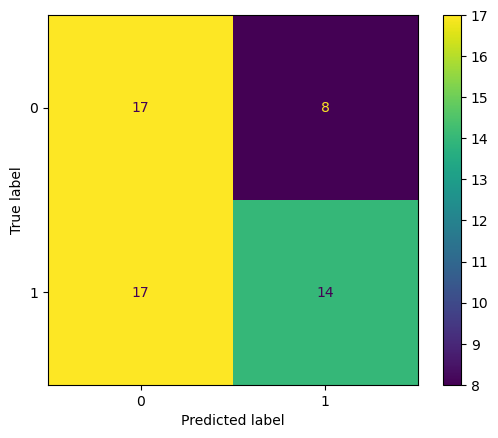

In [116]:
dt_pipeline.fit(Train3x, Train3y)
dtpredBest = dt_pipeline.predict(Test3x)
cmNBBest = confusion_matrix(Test3y, dtpredBest)
print(accuracy_score(Test3y, dtpredBest))
ConfusionMatrixDisplay(confusion_matrix= cmNBBest).plot()

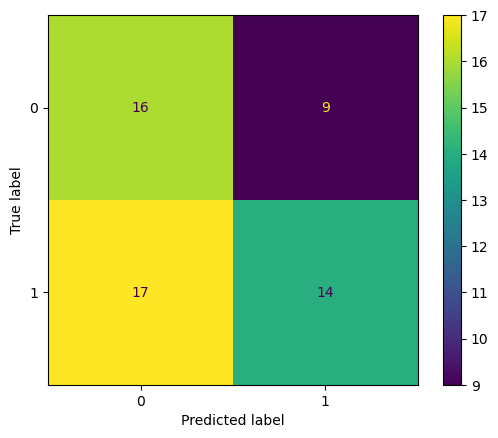

In [117]:
nb_pipeline.fit(Train3x, Train3y)
nbpredBest = nb_pipeline.predict(Test3x)
cmNBBest = confusion_matrix(Test3y, nbpredBest)
accuracy_score(Test3y, nbpredBest)
ConfusionMatrixDisplay(confusion_matrix= cmNBBest).plot()

0.5357142857142857


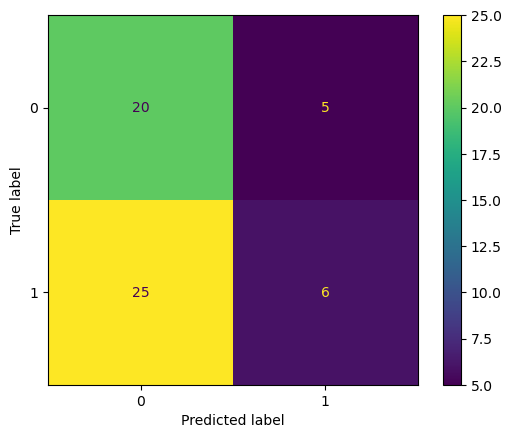

In [118]:
knn_pipeline.fit(Train3x, Train3y)
knnpredBest = knn_pipeline.predict(Test3x)
cmknnBest = confusion_matrix(Test3y, knnpredBest)
print(accuracy_score(Test3y, nbpredBest))
ConfusionMatrixDisplay(confusion_matrix= cmknnBest).plot()

0.6785714285714286


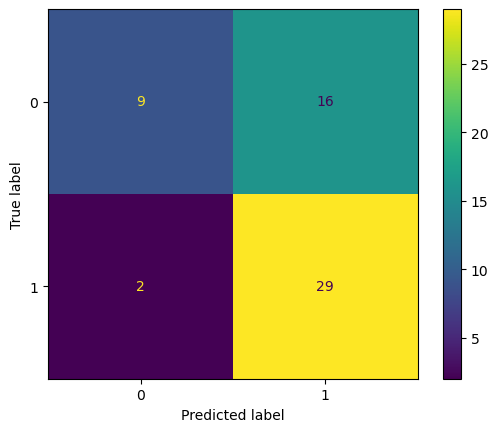

In [119]:
gb_pipeline.fit(Train3x, Train3y)
gbpredBest = gb_pipeline.predict(Test3x)
cmGBBest = confusion_matrix(Test3y, gbpredBest)
print(accuracy_score(Test3y, gbpredBest))
ConfusionMatrixDisplay(confusion_matrix= cmGBBest).plot()

0.5178571428571429


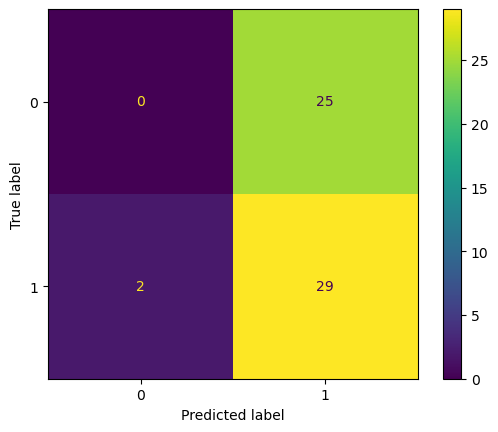

In [120]:
ada_pipeline.fit(Train3x, Train3y)
adapredBest = ada_pipeline.predict(Test3x)
cmadaBest = confusion_matrix(Test3y, adapredBest)
print(accuracy_score(Test3y, adapredBest))
ConfusionMatrixDisplay(confusion_matrix= cmadaBest).plot()

### Stacking the Models for Improved Results

We can't stack these time series models with Sklearn's Stacking Classifier, but we can aggregate the data from each of their predictions, and consider a date where the majority of the classifiers said it would be up to be predict as up in our final model, and vice versa.

In [123]:
# Let's make a pandas dataframe with all 5 of the Y Predictions in our model
allPredsDict = {'DT': dtpredBest, 'NB': nbpredBest, 'KNN': knnpredBest, 'GB': gbpredBest, 'ADA': adapredBest}
allPredsDF = pd.DataFrame(allPredsDict).set_index(Test3y.index)
allPredsDF['Agg_Score'] = (allPredsDF['DT'] + allPredsDF['NB'] + allPredsDF['KNN'] + allPredsDF['GB'] + allPredsDF['ADA']) / 5
allPredsDF['final_prediction'] = allPredsDF['Agg_Score'].apply(lambda x: 1 if x > 0.5 else 0)
allPredsDF.drop('Agg_Score', axis = 1, inplace = True)
allPredsDF.head()

,DT,NB,KNN,GB,ADA,final_prediction
Date,,,,,,
2023-01-10,1,1,1,1,1,1
2023-01-11,0,0,0,1,1,0
2023-01-12,0,0,0,1,1,0
2023-01-13,1,1,1,1,1,1
2023-01-17,0,1,1,0,1,1


In [125]:
# Checking our accuracy of the stacked model
FinalPreds = allPredsDF['final_prediction']
accuracy_score(Test3y, FinalPreds)

0.5714285714285714

## Evaluation

##### Although our accuracy did decrease compared to our lone gradient boost model, this one is much more rigourus and should perform much better on unseen data, so we will use this one.